In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import Module
from torch.optim import *
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import time


In [2]:
print(torch.__version__)
print(torch.version.cuda)

1.5.0
10.2


In [3]:
def PrintResults(predictions, actuals):
    ynp = predictions.numpy()
    testnp = actuals.numpy()
    print("Class \t Cases \t TP \t FP \t Precision \t Recall")
    allcases = 0
    allTP = 0
    allFP = 0
    for i in range(0,6):
        cases = sum(testnp==i)
        allcases += cases
        TP = sum((ynp==i) & (testnp==i))
        allTP += TP
        FP = sum((ynp==i) & (testnp!=i))
        allFP += FP
        Precision = TP / (TP + FP + 0.000000001)
        Recall = TP / cases
        print(i, "\t", cases, "\t" ,TP, "\t", FP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3))
    Precision = allTP / (allTP + allFP + 0.000000001)
    Recall = allTP / allcases
    print("Total", "\t", allcases, "\t" ,allTP, "\t", allFP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3))
    

In [4]:
def Check(Xvals, Yactuals, model):
    predictraw = model(Xvals.to(device)).detach().cpu()
    predict = np.argmax(predictraw, axis=-1)
    predict_score = predict == Yactuals
    correct = np.sum(predict_score.numpy(), axis=-1)
    sumtot = predict_score.shape[0]
    score = correct / sumtot
    return (predict, score)

<function matplotlib.pyplot.show(*args, **kw)>

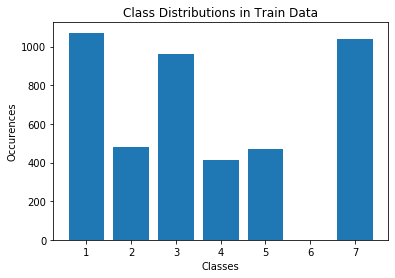

In [205]:
alldata = pd.read_csv("sat.all.csv")
traindata = alldata[alldata['TrainTest'] == 'train']
testdata = alldata[alldata['TrainTest'] == 'test']

distribution = traindata.groupby('Class').count()
plt.bar(distribution.index.values,distribution.iloc[:,0])
plt.xlabel('Classes')
plt.ylabel('Occurences')
plt.title('Class Distributions in Train Data')
plt.show

In [204]:
seed = 7
train, validate = train_test_split(traindata, test_size=0.2, random_state=seed, stratify=traindata['Class'], shuffle=True)

trainX = train.iloc[:,0:36].to_numpy()
trainY= train.iloc[:,36].to_numpy()

valX = validate.iloc[:,0:36].to_numpy()
valY= validate.iloc[:,36].to_numpy()

testX = testdata.iloc[:,0:36].to_numpy()
testY = testdata.iloc[:,36].to_numpy()

for i in range(1,8):
    trainY[trainY==i] = i-1
    valY[valY==i] = i-1
    testY[testY==i] = i-1

trainY[trainY==6] = 5
valY[valY==6] = 5
testY[testY==6] = 5

In [206]:
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scalerFunc = scaler.fit(trainX)

trainX = scalerFunc.transform(trainX)
valX = scalerFunc.transform(valX)
testX = scalerFunc.transform(testX)

#for i in range(0,36):
#    print(' Feature {} \t Train: {:.6f} {:.6f} Validation: {:.6f} {:.6f} Test: {:.6f} {:.6f}'.format(
#          i,
#          min(trainX[:,i]),max(trainX[:,i]),
#          min(valX[:,i]),max(valX[:,i]),
#          min(testX[:,i]),max(testX[:,i])))

In [93]:
trainX_tensor = torch.from_numpy(trainX).float()
trainY_tensor = torch.from_numpy(trainY).float()

valX_tensor = torch.from_numpy(valX).float()
valY_tensor = torch.from_numpy(valY).float()

testX_tensor = torch.from_numpy(testX).float()
testY_tensor = torch.from_numpy(testY).float()


In [140]:
class wame(Optimizer):


    def __init__(self, params,lr=1e-3, alpha=0.9, etas=(0.1, 1.2), zetas=(0.01, 100), epsilon=1e-10, debug=False ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= alpha:
            raise ValueError("Invalid learning rate: {}".format(alpha))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(alpha=alpha, etas=etas, zetas=zetas, lr=lr, epsilon=epsilon, debug=debug)
        super(wame, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
   
        for group in self.param_groups:    
            etaminus, etaplus = group['etas']
            zeta_min, zeta_max = group['zetas']
            alpha = group['alpha']
            lr = group['lr']
            epsilon = group['epsilon']
            debug = group['debug']
            _p = 0

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('wame does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['prev'] = grad
                    state['Theta'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['Z'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['zeta'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['gradmult'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    
                    state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr']) ### check on initialisation
                    state['prev'] = grad
                    
                if (_p == 0) & debug:
                    print("Weights at start: ",p.data.sum(), p.data.size())
                step_size = state['step_size']
                Theta = state['Theta']
                Z = state['Z']
                zeta = state['zeta']
                gradmult = state['gradmult']                    
                
                state['step'] += 1

                gradmult = grad.mul(state['prev'])
                zeta[gradmult.gt(0.)] = zeta[gradmult.gt(0.)].mul(etaplus).clamp(zeta_min, zeta_max)
                zeta[gradmult.lt(0.)] = zeta[gradmult.lt(0.)].mul(etaminus).clamp(zeta_min, zeta_max)
                zeta[gradmult.eq(0.)] = 1
                
                Z = Z.mul(alpha).add(zeta.mul(1 - alpha))
                Theta = Theta.mul(alpha).add(grad.mul(grad).mul(1 - alpha))

                step_size = Z.mul(-lr).mul(grad).div(Theta.add(epsilon))

                grad = grad.clone(memory_format=torch.preserve_format)
                
                # update parameters
                p.data = p.data.add(step_size)
                
                if (_p == 0) & debug:
                    print("Step number ", state['step'])
                    print("Weights after update: ",p.data.sum(), p.data.size())
                    print("Updates applied: ",step_size.sum(), step_size.size())
                    print("Theta: ",Theta.sum())
                    print("Z: ",Z.sum())
                    print("zeta: ",zeta.sum())
                    print("grad: ",grad.sum())
                    print("grad_sqd", grad_sqd.sum())
                    print("gradmult", gradmult.sum())
                state['prev'] = grad
                
                _p = _p + 1

        return loss


In [238]:
in_features = 36
out_classes = 6

class TestModel(Module):
    def __init__(self, num_units=in_features*2):
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(in_features, num_units)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(num_units, out_classes*2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(out_classes*2, out_classes)

    def forward(self, x):
        y = self.fc1(x)
        y = self.relu1(y)
        y = self.fc2(y)
        y = self.relu2(y)
        y = self.fc3(y)
        return y

In [239]:
if torch.cuda.is_available():
    model = torch.nn.DataParallel(TestModel()).cuda()
    device = torch.device("cuda")
else:
    model = TestModel()
    device = torch.device("cpu")
    
print(model)

DataParallel(
  (module): TestModel(
    (fc1): Linear(in_features=36, out_features=72, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=72, out_features=12, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=12, out_features=6, bias=True)
  )
)


In [240]:
batch_size = 512
optName = "Adam"

if optName == "Wame":
    opt = wame(model.parameters(), lr=1e-6)
if optName == "SGD":
    opt = SGD(model.parameters(), lr=1e-1)
if optName == "Adam":
    opt = Adam(model.parameters(), lr=1e-2)

loss = CrossEntropyLoss().to(device)
epochs = 200


trainXY_tensor = TensorDataset(trainX_tensor, trainY_tensor)
train_loader = DataLoader(trainXY_tensor, batch_size=batch_size)

In [241]:
time0 = time.perf_counter()
time00 = time0
torch.manual_seed(7)

accuracies = []
validations = []
errors = []

train_score = 0
epoch = 0
accuracy_change = 100
prev_accuracy = 0

while ((epoch < epochs) & (train_score < 0.99) ):
    batch = 0
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)
        opt.zero_grad()
        predict_y = model(train_x)
        error = loss(predict_y, train_label.long())
        error.backward()
        opt.step()

        batch = batch + 1
    

    train_pred, train_score = Check(trainX_tensor, trainY_tensor, model)
    error = loss(model(trainX_tensor), trainY_tensor.to(device).long())
    val_pred, val_score = Check(valX_tensor, valY_tensor, model)

    time1 = time.perf_counter()
    print('epoch: {} \t accuracy: {:.6f} error: {:.6f} validation accuracy: {:.6f} time {:.3f}s'.format(
        epoch + 1, train_score, error, val_score, time1 - time0))
    time0 = time1
    accuracies.append(train_score)
    validations.append(val_score)
    errors.append(error)
    
    accuracy_change = train_score - prev_accuracy
    prev_accuracy = train_score
    
    epoch += 1
    
time01 = time.perf_counter()
print('Overall time {:.3f} seconds'.format(time01 - time00))

epoch: 1 	 accuracy: 0.755355 error: 0.845904 validation accuracy: 0.757610 time 0.056s
epoch: 2 	 accuracy: 0.840474 error: 0.502967 validation accuracy: 0.845547 time 0.039s
epoch: 3 	 accuracy: 0.836809 error: 0.429974 validation accuracy: 0.838782 time 0.037s
epoch: 4 	 accuracy: 0.850902 error: 0.382137 validation accuracy: 0.843292 time 0.036s
epoch: 5 	 accuracy: 0.856257 error: 0.361854 validation accuracy: 0.848929 time 0.032s
epoch: 6 	 accuracy: 0.858230 error: 0.342835 validation accuracy: 0.851184 time 0.042s
epoch: 7 	 accuracy: 0.862176 error: 0.329928 validation accuracy: 0.862458 time 0.041s
epoch: 8 	 accuracy: 0.866685 error: 0.321110 validation accuracy: 0.855693 time 0.035s
epoch: 9 	 accuracy: 0.872041 error: 0.312464 validation accuracy: 0.856821 time 0.034s
epoch: 10 	 accuracy: 0.875423 error: 0.303442 validation accuracy: 0.852311 time 0.036s
epoch: 11 	 accuracy: 0.880214 error: 0.292462 validation accuracy: 0.868095 time 0.033s
epoch: 12 	 accuracy: 0.884724

In [242]:
PrintResults(train_pred, trainY_tensor)

Class 	 Cases 	 TP 	 FP 	 Precision 	 Recall
0 	 858 	 858 	 0 	 1.0 	 	 1.0
1 	 383 	 383 	 0 	 1.0 	 	 1.0
2 	 769 	 762 	 11 	 0.986 	 	 0.991
3 	 332 	 318 	 14 	 0.958 	 	 0.958
4 	 376 	 375 	 1 	 0.997 	 	 0.997
5 	 830 	 820 	 6 	 0.993 	 	 0.988
Total 	 3548 	 3516 	 32 	 0.991 	 	 0.991


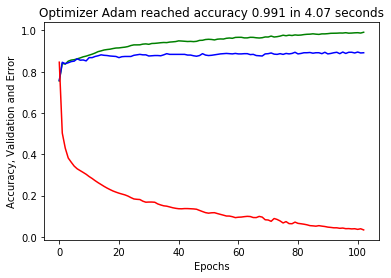

In [243]:
plotrange = epoch

plt.plot(range(plotrange), accuracies[0:plotrange], color='green')
plt.plot(range(plotrange), validations[0:plotrange], color='blue')
plt.plot(range(plotrange), errors[0:plotrange], color='r')
title = "Optimizer {} reached accuracy {:.3f} in {:.2f} seconds".format(optName, train_score, time01 - time00)
plt.xlabel('Epochs')
plt.ylabel('Accuracy, Validation and Error')
plt.title(title)
plt.show()

In [235]:
PrintResults(val_pred, valY_tensor)

Class 	 Cases 	 TP 	 FP 	 Precision 	 Recall
0 	 214 	 208 	 5 	 0.977 	 	 0.972
1 	 96 	 92 	 2 	 0.979 	 	 0.958
2 	 192 	 166 	 16 	 0.912 	 	 0.865
3 	 83 	 54 	 30 	 0.643 	 	 0.651
4 	 94 	 81 	 15 	 0.844 	 	 0.862
5 	 208 	 186 	 32 	 0.853 	 	 0.894
Total 	 887 	 787 	 100 	 0.887 	 	 0.887


In [236]:
predict_ys, _ = Check(testX_tensor, testY_tensor, model)

In [237]:
PrintResults(predict_ys, testY_tensor)    

Class 	 Cases 	 TP 	 FP 	 Precision 	 Recall
0 	 461 	 455 	 15 	 0.968 	 	 0.987
1 	 224 	 216 	 8 	 0.964 	 	 0.964
2 	 397 	 341 	 30 	 0.919 	 	 0.859
3 	 211 	 149 	 72 	 0.674 	 	 0.706
4 	 237 	 212 	 25 	 0.895 	 	 0.895
5 	 470 	 415 	 62 	 0.87 	 	 0.883
Total 	 2000 	 1788 	 212 	 0.894 	 	 0.894
